This file takes in cropped satellite image of a city and produces images chips and saves them as numpy arrays. I've used Sentinale image with a resolution of 10 meters and 'EPSG:32610 - WGS 84 / UTM zone 10N - Projected' CRS

The bands of the images are - blue, green, red, nir, ndvi, landcover (from ESA landcover), swir, ndbi, vari

The output chips have only 3 bands, and are filtered - only chips that have more then a thershold (e.g. 15%, 20%) of parks are saved to have a bit more balanced dataset.

In [ ]:
#install packages
#!pip install pyrsgis
#!pip install rasterio
#!pip install patchify

In [ ]:
# Connecting to the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import rasterio
import numpy as np
from osgeo import gdal

#image
image = gdal.Open('location of tif image')
park = gdal.Open('location of park image')

print(image)
print(park)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f67e7504f00> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f67e7504f30> >


In [ ]:
# turn image into array
image_array = image.ReadAsArray()
print(image_array.shape)

#change negative ndvi values to 0
#image_array[4][image_array[4] < 0] = 0
image_array = np.transpose(image_array, [1, 2, 0]) # transpose the bands to the third dimension
print(image_array.shape)

(9, 2196, 1820)
(2196, 1820, 9)


In [ ]:
#turn park into array
park_array = park.ReadAsArray()
park_array = np.expand_dims(park_array, axis = 2) #expand the dimention so it matched the sattelite images
print(park_array.shape)

(2195, 1820, 1)


Leave only 3 bands - ndvi, landcover, ndbi

In [ ]:
image_array = image_array[:,:,[4,5,7]]

In [ ]:
image_array.shape

(2196, 1820, 3)

patchify to create image patches

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff

from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
#divide all images into patches 
patch_size = 256
step = 20
image_dataset = []  
scaler = MinMaxScaler()

#Extract patches from each image
patches_img = patchify(image_array, (patch_size, patch_size, 3), step=step)  
for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,:,:] 
    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                    
    image_dataset.append(single_patch_img) 

image_dataset = np.array(image_dataset)
image_dataset.shape

(7742, 256, 256, 3)

and now for parks

In [ ]:
#divide all images into patches 
park_dataset = []  
#same patch size and stride as for image
scaler = MinMaxScaler()

#Extract patches from each image
patches_img = patchify(park_array, (patch_size, patch_size, 1), step=step)  #HERE ADD STRIDE
for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,:,:] 
    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.     
    park_dataset.append(single_patch_img) 

park_dataset = np.array(park_dataset)
park_dataset.shape

(7663, 256, 256, 1)

In [ ]:
#check the datasets
print(image_dataset.shape)
print(image_dataset.max())
print(image_dataset.min())
print(np.unique(park_dataset))

(7742, 256, 256, 3)
1.0000001
0.0
[0. 1.]


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

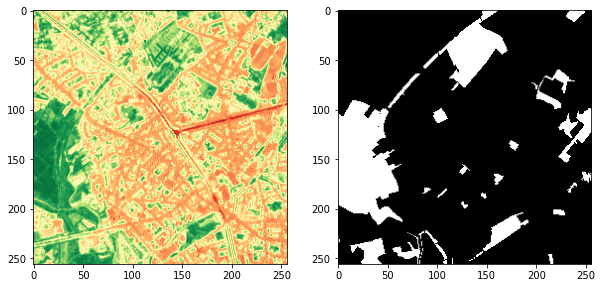

In [ ]:
# check whether the cropped images match

# generate random number
image_number = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(10, 5))

# plot satellite image with nir (more visible green areas then with true-color) 
plt.subplot(121)
plt.imshow(image_dataset[image_number,:,:,1], cmap='RdYlGn')

# plot parks - white is park
plt.subplot(122)
plt.imshow(park_dataset[image_number,:,:,0], cmap='gray')
plt.show()

Delete chips that have less then 20% of park

In [ ]:
chips_20_parks = []
for i in range(len(park_dataset)):
  one_chip = park_dataset[i, :, :, 0]
  one_chip = one_chip.flatten()
  pixel_n = len(one_chip)
  park_pixel = sum(one_chip == 1)
  #print(park)
  if park_pixel >= 0.2 *pixel_n:
    chips_20_parks.append(i)

In [ ]:
len(chips_20_parks)

220

In [ ]:
image_dataset_balanced = []
park_dataset_balanced = []
for i in range(len(image_dataset)):
  if i in chips_20_parks:
    image_copy = image_dataset[i]
    park_copy = park_dataset[i]
    image_dataset_balanced.append(image_copy)
    park_dataset_balanced.append(park_copy)
image_dataset_balanced = np.array(image_dataset_balanced)
park_dataset_balanced = np.array(park_dataset_balanced)
print(image_dataset_balanced.shape)
print(park_dataset_balanced.shape)

(220, 256, 256, 3)
(220, 256, 256, 1)


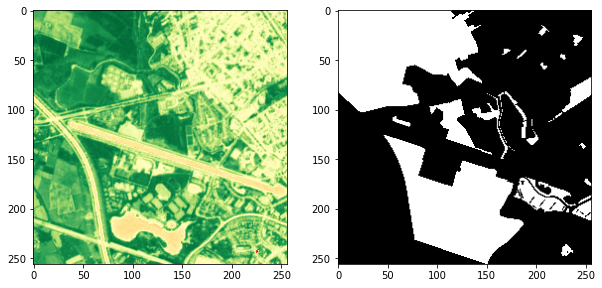

In [ ]:
# check whether the cropped images match

# generate random number
image_number = random.randint(0, len(image_dataset_balanced)-1)
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(image_dataset_balanced[image_number,:,:,1], cmap='RdYlGn')

# plot parks
plt.subplot(122)
plt.imshow(park_dataset_balanced[image_number,:,:,0], cmap='gray')
plt.show()




Save to numpy arrays

In [ ]:
#image
np.save('location to save image chips', image_dataset_balanced)


In [ ]:

#parks
np.save('location to save park chips', park_dataset_balanced)

